<a href="https://colab.research.google.com/github/pooshanchatterjee/CLIP-finetuning/blob/main/main_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


!pip install openai-clip
!pip install datasets
!pip install torch
!pip install tqdm

In [ ]:
from PIL import Image

import matplotlib.pyplot as plt

from datasets import load_dataset

import clip
import torch
import torch.nn as nn


from torch.utils.data import random_split
from torchvision import transforms
from torch.utils.data import Dataset

from torch.utils.data import DataLoader

import torch.optim as optim

In [ ]:
ds = load_dataset("zmao/food_img_caption_small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/813 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'image'],
        num_rows: 813
    })
})

In [ ]:
entry = ds['train'][0]
entry

{'text': 'Small/1 3 cake',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=274x169>}

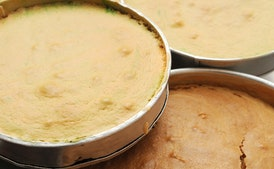

In [ ]:
image = entry['image']
image

In [ ]:
entry['text']

'Small/1 3 cake'

In [ ]:
dataset = ds['train']

In [ ]:
dataset

Dataset({
    features: ['text', 'image'],
    num_rows: 813
})

In [ ]:
def remove_prefix(text):
    if text.startswith("Small/"):
        return text[len("Small/"):]
    return text

def preprocess_texts(examples):
    examples['text'] = [remove_prefix(text) for text in examples['text']]
    return examples

dataset = dataset.map(preprocess_texts, batched=True)


Example 6:


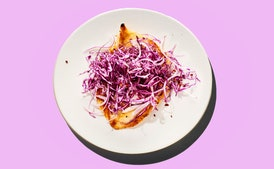

Text: 15 minute chicken paillards with red cabbage and onion slaw


Example 7:


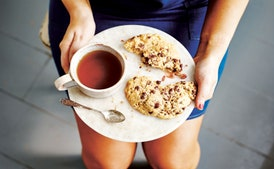

Text: 2 minute microwave chocolate chip pecan cookie


Example 8:


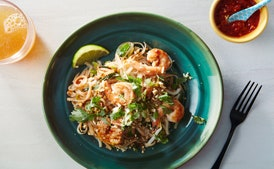

Text: 22 minute pad thai


Example 9:


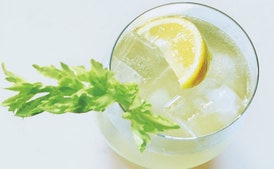

Text: 24th street spritz


Example 10:


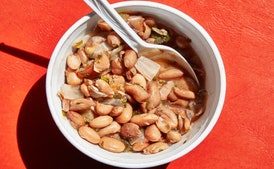

Text: 2m smokehouse charro beans




In [ ]:
for i in range(5,10):
    print(f"Example {i+1}:")
    display(dataset[i+1]['image'])
    print(f"Text: {dataset[i+1]['text']}")
    print("\n")

In [ ]:
# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
# Inference

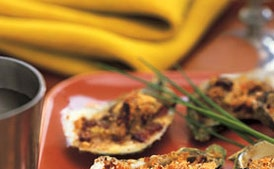

Predicted: baked oysters with bacon and leeks, Actual: baked oysters with bacon and leeks


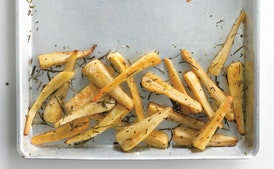

Predicted: baked parsnip fries with rosemary, Actual: baked parsnip fries with rosemary


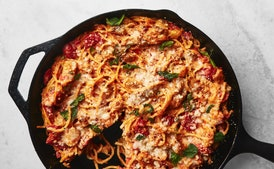

Predicted: bbq chicken french bread pizzas with smoked mozzarella, Actual: baked pasta alla norma


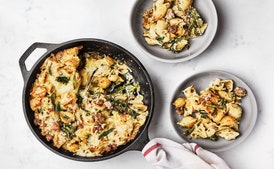

Predicted: artichoke and mushroom frittata, Actual: baked pasta shells with sausage and greens


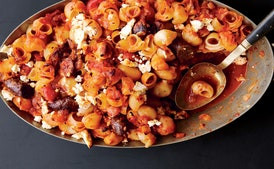

Predicted: bacon and cashew caramel corn, Actual: baked pasta with merguez and harissa spiked sauce


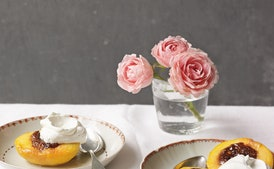

Predicted: apricot raspberry pavlovas with sliced almonds, Actual: baked peaches with amaretti and cocoa


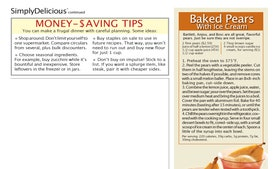

Predicted: 3 ingredient thanksgiving turkey with orange and sage, Actual: baked pears with ice cream


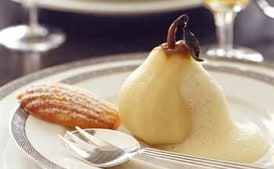

Predicted: baked pears with sauternes custard sauce, Actual: baked pears with sauternes custard sauce


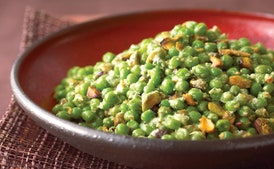

Predicted: barley and corn salad with basil chive dressing, Actual: baked peas with tarragon yogurt and pistachios


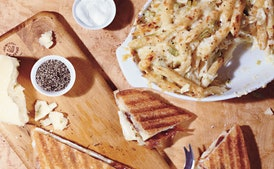

Predicted: baked penne with farmhouse cheddar and leeks, Actual: baked penne with farmhouse cheddar and leeks
Accuracy: 0.4


In [ ]:
# Select indices for three example images
indices = list(range(650,660))

n_samples = len(indices)
# Get the list of possible subcategories from the dataset
subcategories = list(set(example['text'] for example in dataset))

# Preprocess the text descriptions for each subcategory
text_inputs = torch.cat([clip.tokenize(f"a photo of {c}") for c in subcategories]).to(device)

correct = 0
# Create a figure with subplots
# fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Select an example image from the dataset
    example = dataset[idx]
    image = example['image']
    subcategory = example['text']

    # Preprocess the image
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Calculate image and text features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity between image and text features
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)

    # Display the image in the subplot
    display(image)
    print(f"Predicted: {subcategories[indices[0]]}, Actual: {subcategory}")
    correct += int(subcategories[indices[0]]==subcategory)
    # axes[i].axis('off')

print(f'Accuracy: {correct/n_samples}')

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# Define your custom dataset class
class FoodDataset(Dataset):
    def __init__(self, data, subcategories):
        self.data = data
        self.subcategories = subcategories
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
        self.tokenizer = clip.tokenize

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        subcategory = item['text']
        text = self.tokenizer([subcategory])[0]  # Tokenize text
        label = self.subcategories.index(subcategory)

        # return self.transform(image), text, label

        return self.transform(image), text

In [ ]:
# Instantiate the dataset
# transform = transforms.Compose([
#     preprocess
# ])

In [ ]:
clip.tokenize('baked penne with farmhouse cheddar and leeks')[0]

tensor([49406, 10364,  1501,  1422,   593, 26293, 20551,   537,  6224,   662,
        49407,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], dtype=torch.int32)

In [ ]:
dataset = FoodDataset(dataset, subcategories=subcategories)

In [ ]:
image, text = dataset.__getitem__(1)
image.to(device)
print(image)
text.to(device)
print(text)
# label.to(device)
# print(label)

tensor([[[ 1.5654,  1.6092,  1.6384,  ..., -0.3616, -0.0842, -0.0842],
         [ 1.5800,  1.6092,  1.6384,  ..., -0.2302, -0.0696, -0.0696],
         [ 1.5946,  1.6092,  1.6384,  ..., -0.0550, -0.0842, -0.0113],
         ...,
         [ 1.3610,  1.3902,  1.4340,  ...,  1.4486,  1.5070,  1.4632],
         [ 1.3172,  1.3464,  1.4048,  ...,  1.4486,  1.4632,  1.3756],
         [ 1.2588,  1.3026,  1.3610,  ...,  1.4340,  1.4194,  1.4194]],

        [[ 1.7447,  1.7297,  1.6997,  ...,  0.2740,  0.6491,  0.6642],
         [ 1.7297,  1.7297,  1.6997,  ...,  0.4090,  0.6491,  0.6642],
         [ 1.7297,  1.7297,  1.6997,  ...,  0.5741,  0.6191,  0.6942],
         ...,
         [ 1.4746,  1.5196,  1.5796,  ...,  1.5796,  1.5946,  1.5496],
         [ 1.5046,  1.5046,  1.5646,  ...,  1.5796,  1.6247,  1.5796],
         [ 1.5196,  1.5046,  1.5346,  ...,  1.5496,  1.5646,  1.5646]],

        [[ 1.9326,  1.9326,  1.9326,  ...,  1.2643,  1.6909,  1.6909],
         [ 1.9326,  1.9326,  1.9326,  ...,  1

In [ ]:
# dataset.transform

In [ ]:
# Split the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
test_dataset.__len__()

163

In [ ]:
import torch.nn.functional as F

In [ ]:
# class FineTuneCLIP(nn.Module):
#     def __init__(self, model, num_classes):
#         super(FineTuneCLIP, self).__init__()
#         self.model = model
#         self.classifier = nn.Linear(model.visual.output_dim, num_classes)

#     def forward(self, images, texts):
#         # Encode images and texts
#         image_features = self.model.encode_image(images)
#         text_features = self.model.encode_text(texts)

#         # Convert to float32 to ensure consistent dtype
#         image_features = image_features.float()
#         text_features = text_features.float()

#         # Combine features (e.g., average them)
#         combined_features = (image_features + text_features) / 2

#         # Pass combined features through classifier
#         logits = self.classifier(combined_features)
#         return logits

class FineTuneCLIP(nn.Module):
    def __init__(self, model):
        super(FineTuneCLIP, self).__init__()
        self.model = model  # Pre-trained CLIP model

    def forward(self, images, texts):
        # Encode images and texts
        image_features = self.model.encode_image(images)
        text_features = self.model.encode_text(texts)

        # Normalize features to unit vectors
        image_features = F.normalize(image_features, p=2, dim=-1)
        text_features = F.normalize(text_features, p=2, dim=-1)

        return image_features, text_features

def contrastive_loss(image_features, text_features, temperature=0.07):
    # Calculate cosine similarity between image and text features
    logits = torch.matmul(image_features, text_features.T) / temperature

    # Create labels for contrastive learning
    labels = torch.arange(logits.size(0)).to(logits.device)

    # Calculate cross-entropy loss
    loss = F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)
    return loss / 2


In [ ]:
# Instantiate the model
num_classes = len(subcategories)
model = model.float()

# fine_tune_model = FineTuneCLIP(model, num_classes)
# fine_tune_model.to(device)

fine_tune_model = FineTuneCLIP(model).to(device)

In [ ]:
# Define loss and optimizer
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tune_model.parameters(), lr=1e-15)
temperature = 0.07

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 5

loss_values = []

for epoch in range(num_epochs):
    fine_tune_model.train()
    running_loss = 0.0

    for images, texts in train_loader:
        images = images.to(device)
        texts = texts.to(device)

        optimizer.zero_grad()

        # Forward pass
        image_features, text_features = fine_tune_model(images, texts)

        # Compute contrastive loss
        loss = contrastive_loss(image_features, text_features, temperature)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)  # Store the average loss for visualization
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Evaluate on the validation set
    fine_tune_model.eval()
    correct_image_to_text = 0
    correct_text_to_image = 0
    total = 0

    with torch.no_grad():
        for images, texts in test_loader:
            images = images.to(device)
            texts = texts.to(device)

            # Forward pass
            image_features, text_features = fine_tune_model(images, texts)

            # Calculate similarities
            logits_image_to_text = torch.matmul(image_features, text_features.T) / temperature
            logits_text_to_image = torch.matmul(text_features, image_features.T) / temperature

            # Get the top-1 prediction for both directions
            _, predicted_image_to_text = torch.max(logits_image_to_text, dim=1)
            _, predicted_text_to_image = torch.max(logits_text_to_image, dim=1)

            # Labels are the index of the matching pair
            labels = torch.arange(logits_image_to_text.size(0)).to(device)

            # Calculate correct predictions for both directions
            correct_image_to_text += (predicted_image_to_text == labels).sum().item()
            correct_text_to_image += (predicted_text_to_image == labels).sum().item()
            total += labels.size(0)

    # Calculate and print accuracy
    accuracy_image_to_text = 100 * correct_image_to_text / total
    accuracy_text_to_image = 100 * correct_text_to_image / total
    avg_accuracy = (accuracy_image_to_text + accuracy_text_to_image) / 2

    print(f'Validation Accuracy: Image-to-Text: {accuracy_image_to_text:.2f}%, Text-to-Image: {accuracy_text_to_image:.2f}%, Avg: {avg_accuracy:.2f}%')




Epoch [1/5], Loss: 1.2747
Validation Accuracy: Image-to-Text: 79.14%, Text-to-Image: 76.07%, Avg: 77.61%
Epoch [2/5], Loss: 1.2826
Validation Accuracy: Image-to-Text: 79.14%, Text-to-Image: 76.07%, Avg: 77.61%
Epoch [3/5], Loss: 1.2712
Validation Accuracy: Image-to-Text: 79.14%, Text-to-Image: 76.07%, Avg: 77.61%
Epoch [4/5], Loss: 1.2891
Validation Accuracy: Image-to-Text: 79.14%, Text-to-Image: 76.07%, Avg: 77.61%
Epoch [5/5], Loss: 1.2742
Validation Accuracy: Image-to-Text: 79.14%, Text-to-Image: 76.07%, Avg: 77.61%


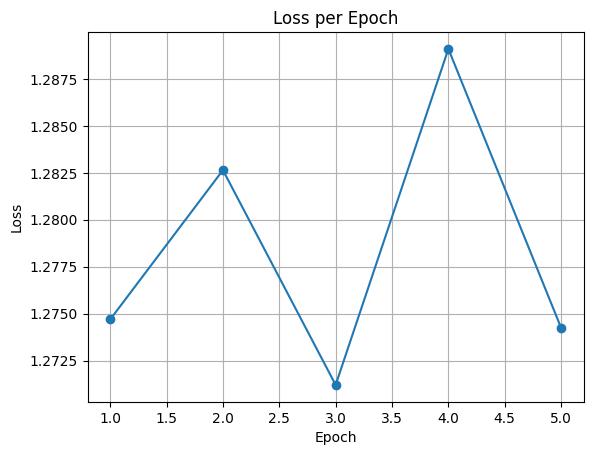

In [ ]:
# After the training loop, plot the loss values

plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
fine_tune_model.eval()  # Set the model to evaluation mode

image_features_list = []
text_features_list = []

with torch.no_grad():  # Disable gradient calculation
    for images, texts in test_loader:  # Use validation loader
        images = images.to(device)
        texts = texts.to(device)

        # Get the image and text features
        image_features, text_features = fine_tune_model(images, texts)

        # Store the features for later evaluation
        image_features_list.append(image_features)
        text_features_list.append(text_features)


In [ ]:
batch_size=32

In [ ]:
# Concatenate all features
image_features = torch.cat([f for f in image_features_list if f.size(0) == batch_size])
text_features = torch.cat([f for f in text_features_list if f.size(0) == batch_size])

# Compute similarity
similarity_matrix = torch.matmul(image_features, text_features.T)

In [ ]:
similarity_matrix

tensor([[ 0.3302,  0.1555,  0.0818,  ...,  0.0595,  0.0825,  0.0534],
        [ 0.0134,  0.3085,  0.2465,  ...,  0.1066,  0.0326,  0.0316],
        [ 0.0865,  0.0683,  0.1182,  ...,  0.0718,  0.1392,  0.1520],
        ...,
        [ 0.0954, -0.0127,  0.1244,  ...,  0.3561,  0.0885,  0.0558],
        [ 0.1436,  0.0378,  0.0254,  ...,  0.0446,  0.3026,  0.2464],
        [ 0.0818,  0.1194,  0.1425,  ...,  0.0519,  0.1364,  0.3291]],
       device='cuda:0')

In [ ]:
def compute_recall_at_k(similarity_matrix, k):
    """Compute Recall@K."""
    correct = 0
    for i in range(similarity_matrix.size(0)):
        # Get the ranks of the text descriptions based on similarity to the image
        sorted_indices = torch.argsort(similarity_matrix[i], descending=True)

        # Check if the correct text is within the top k
        if i in sorted_indices[:k]:
            correct += 1

    return correct / similarity_matrix.size(0)

def compute_mean_rank(similarity_matrix):
    """Compute the Mean Rank."""
    ranks = []
    for i in range(similarity_matrix.size(0)):
        sorted_indices = torch.argsort(similarity_matrix[i], descending=True)
        rank = (sorted_indices == i).nonzero(as_tuple=True)[0].item() + 1
        ranks.append(rank)

    return sum(ranks) / len(ranks)

# Calculate Recall@K
recall_at_1 = compute_recall_at_k(similarity_matrix, 1)
recall_at_5 = compute_recall_at_k(similarity_matrix, 5)
recall_at_10 = compute_recall_at_k(similarity_matrix, 10)

# Calculate Mean Rank
mean_rank = compute_mean_rank(similarity_matrix)

print(f'Recall@1: {recall_at_1:.4f}')
print(f'Recall@5: {recall_at_5:.4f}')
print(f'Recall@10: {recall_at_10:.4f}')
print(f'Mean Rank: {mean_rank:.2f}')


Recall@1: 0.6813
Recall@5: 0.9250
Recall@10: 0.9437
Mean Rank: 3.12


In [ ]:

# num_epochs = 20  # Set the number of epochs

# for epoch in range(num_epochs):
#     fine_tune_model.train()
#     running_loss = 0.0

#     for images, texts, labels in train_loader:
#         images = images.to(device)
#         texts = texts.to(device)  # Tokenized text
#         labels = labels.to(device)

#         optimizer.zero_grad()

#         # Forward pass
#         outputs = fine_tune_model(images, texts)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     avg_loss = running_loss / len(train_loader)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

#     # Evaluate on the test set
#     fine_tune_model.eval()
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for images, texts, labels in test_loader:
#             images = images.to(device)
#             texts = texts.to(device)  # Tokenized text
#             labels = labels.to(device)

#             outputs = fine_tune_model(images, texts)
#             _, predicted = torch.max(outputs.data, 1)

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Test Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 6.6033
Test Accuracy: 0.00%
Epoch [2/20], Loss: 6.3450
Test Accuracy: 0.61%
Epoch [3/20], Loss: 6.2675
Test Accuracy: 0.61%
Epoch [4/20], Loss: 6.1984
Test Accuracy: 0.00%
Epoch [5/20], Loss: 6.1352
Test Accuracy: 0.61%
Epoch [6/20], Loss: 6.0723
Test Accuracy: 0.61%
Epoch [7/20], Loss: 5.9944
Test Accuracy: 0.61%
Epoch [8/20], Loss: 5.9365
Test Accuracy: 0.61%
Epoch [9/20], Loss: 5.8485
Test Accuracy: 0.61%
Epoch [10/20], Loss: 5.7940
Test Accuracy: 0.00%
Epoch [11/20], Loss: 5.6829
Test Accuracy: 0.00%
Epoch [12/20], Loss: 5.6238
Test Accuracy: 0.61%
Epoch [13/20], Loss: 5.4767
Test Accuracy: 0.00%
Epoch [14/20], Loss: 5.4442
Test Accuracy: 0.00%
Epoch [15/20], Loss: 5.3456
Test Accuracy: 0.00%
Epoch [16/20], Loss: 5.2272
Test Accuracy: 0.00%
Epoch [17/20], Loss: 5.0777
Test Accuracy: 0.00%
Epoch [18/20], Loss: 4.9776
Test Accuracy: 0.00%
Epoch [19/20], Loss: 4.8321
Test Accuracy: 0.00%
Epoch [20/20], Loss: 4.6300
Test Accuracy: 0.00%


In [ ]:
# Save the fine-tuned model
torch.save(fine_tune_model.state_dict(), r'/content/drive/MyDrive/clip eagleview/clip_finetuned.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load the model
fine_tune_model = FineTuneCLIP(model).to(device)
fine_tune_model.load_state_dict(torch.load(r'/content/drive/MyDrive/clip eagleview/clip_finetuned.pth'))
fine_tune_model.to(device)
fine_tune_model.eval()

<ipython-input-48-2e568c7abb83>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fine_tune_model.load_state_dict(torch.load(r'/content/drive/MyDrive/clip eagleview/clip_fine

FineTuneCLIP(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizab

In [ ]:
# visualisations

In [ ]:
from tqdm import tqdm

In [ ]:
def evaluate_model(fine_tune_model, processor, test_loader, device="cuda", top_k=10):
    """
    Evaluate the fine-tuned CLIP model on the test dataset.

    Args:
    - fine_tune_model (torch.nn.Module): The fine-tuned CLIP model.
    - processor (CLIPProcessor): The processor for preprocessing text and images.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - device (str): The device to perform evaluation on.
    - top_k (int): Number of top predictions to retrieve.

    Returns:
    - predictions (list): List of lists containing top-k predictions for each image.
    - actual_captions (list): List of actual captions for each image.
    - images (list): List of images from the dataset.
    """

    fine_tune_model.eval()  # Set the model to evaluation mode
    image_features_list = []
    text_features_list = []
    images = []
    actual_captions = []

    with torch.no_grad():  # Disable gradient calculation
        for batch_images, batch_texts in tqdm(test_loader):
            batch_images = batch_images.to(device)
            batch_texts = batch_texts.to(device)

            # Process the texts
            # inputs = processor(text=batch_texts, images=batch_images, return_tensors="pt", padding=True).to(device)
            images.extend(batch_images)  # Store original images for later use
            actual_captions.extend(batch_texts)  # Store the actual captions

            # Get the image and text features
            image_features, text_features = fine_tune_model(batch_images, batch_texts)

            # Normalize the features
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # Store the features for later evaluation
            image_features_list.append(image_features)
            text_features_list.append(text_features)

    # Stack all the features
    image_features = torch.cat(image_features_list, dim=0)
    text_features = torch.cat(text_features_list, dim=0)

    # Compute cosine similarity between image and text features
    similarity_matrix = image_features @ text_features.T

    # Get the top-k predictions for each image
    top_k_indices = similarity_matrix.topk(k=top_k, dim=-1).indices.cpu().numpy()

    # Retrieve the corresponding captions
    predictions = []
    for indices in top_k_indices:
        predicted_captions = [actual_captions[idx] for idx in indices]
        predictions.append(predicted_captions)

    return predictions, actual_captions, images




def display_image_to_text_matching(images, predictions, actual_captions, top_k=10):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 4))

    for i in range(num_images):
        img = images[i] if isinstance(images[i], Image.Image) else Image.open(images[i])

        # Display the image
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')

        # Display the top-k predictions with color-coding
        for j in range(top_k):
            color = "green" if predictions[i][j] == actual_captions[i] else "red"
            axes[i, 1].text(0, j, f"{j+1}. {predictions[i][j]}", fontsize=12, color=color, verticalalignment='center')

        axes[i, 1].set_axis_off()

    plt.tight_layout()
    plt.show()


In [ ]:
def display_image_to_text_matching(images, predictions, actual_captions, top_k=10):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 4))

    for i in range(num_images):
        img = images[i]

        # Display the image
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')

        # Display the top-k predictions with color-coding
        for j in range(top_k):
            # Check if predictions[i][j] is a tensor and all values are True
            if isinstance(predictions[i][j], torch.Tensor):
                is_correct = torch.all(predictions[i][j]).item()
            else:
                is_correct = predictions[i][j] == actual_captions[i]

            color = "green" if is_correct else "red"
            axes[i, 1].text(0, j, f"{j+1}. {predictions[i][j]}", fontsize=12, color=color, verticalalignment='center')

        axes[i, 1].set_axis_off()

    plt.tight_layout()
    plt.show()

In [ ]:
dataset1 = ds['train']

dataset1 = dataset1.map(preprocess_texts, batched=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset1, test_dataset1 = random_split(dataset1, [train_size, test_size])


In [ ]:
actual_images = []
# actual_captions = []
for ex in test_dataset1:
  actual_images.append(ex['image'])
  # actual_captions.append(ex['text'])
# for idx in range(5):
#   ex = test_dataset1[idx]
#   display(ex['image'])
#   print(ex['text'])
#   print()

In [ ]:
test_loader1 = DataLoader(FoodDataset(test_dataset1, subcategories = actual_captions), batch_size=32, shuffle=False)

In [ ]:
predictions, actual_captions, images = evaluate_model(fine_tune_model, preprocess, test_loader1)

100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


<ipython-input-151-489c3fc50b20>:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


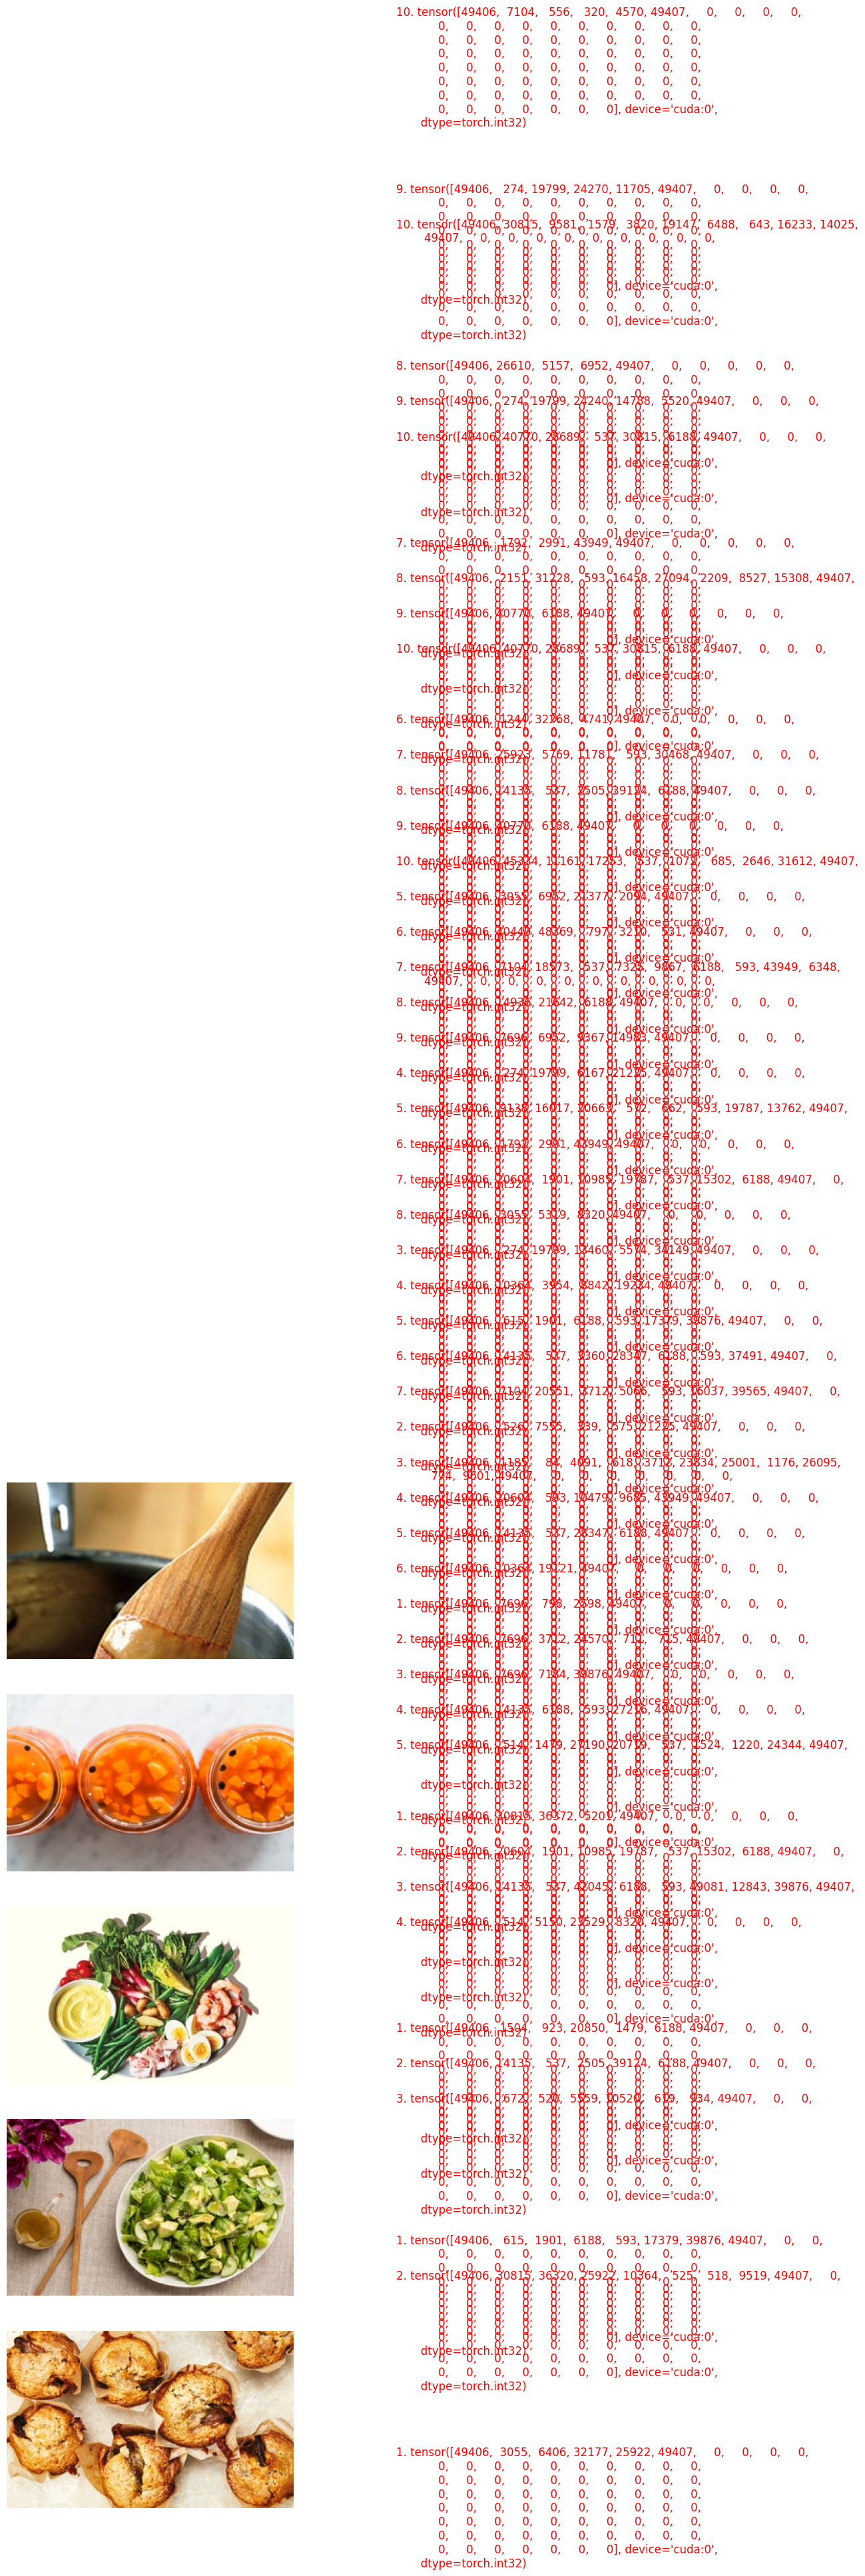

In [ ]:
display_image_to_text_matching(actual_images[:5], predictions[:5], actual_captions[:5], top_k=10)

In [ ]:
actual_captions[1]

RuntimeError: a Tensor with 77 elements cannot be converted to Scalar

In [ ]:
predictions[0][1] == actual_captions[0]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True], device='cuda:0')